# Import libraries and dataset

In [3]:
import os
import cv2
import shutil
# import imutils
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import normalize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# IGNORING UNNECESSARRY WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [4]:
base_dir = '/kaggle/input/classification-dataset/healthy_and_tumor'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Helper function for loading images/labels into numpy arrays

In [5]:
def load_images_and_labels(base_dir, labels, color_mode='rgb'):
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    for label in labels:
        # Load training images
        train_dir = os.path.join(base_dir, 'train', label)
        for img_name in os.listdir(train_dir):
            img_path = os.path.join(train_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_train.append(img)
                y_train.append(labels.index(label))

        # Load validation images
        val_dir = os.path.join(base_dir, 'validation', label)
        for img_name in os.listdir(val_dir):
            img_path = os.path.join(val_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_val.append(img)
                y_val.append(labels.index(label))

        # Load test images
        test_dir = os.path.join(base_dir, 'test', label)
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_test.append(img)
                y_test.append(labels.index(label))

    # Convert lists to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Understand shape of train/validation/test set

In [6]:
labels = ['healthy', 'tumor']

x_train, y_train, x_val, y_val, x_test, y_test = load_images_and_labels(base_dir, labels, color_mode='rgb')

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2100, 224, 224, 3)
y_train shape: (2100,)
x_val shape: (450, 224, 224, 3)
y_val shape: (450,)
x_test shape: (450, 224, 224, 3)
y_test shape: (450,)


# Shuffle dataset and normalize test set

Note: The train and validation sets will be normalized during augmentation

In [7]:
# Shuffle the training data
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices]
y_train = y_train[train_indices]

# Shuffle the validation data
val_indices = np.arange(x_val.shape[0])
np.random.shuffle(val_indices)
x_val = x_val[val_indices]
y_val = y_val[val_indices]

# Shuffle the test data
test_indices = np.arange(x_test.shape[0])
np.random.shuffle(test_indices)
x_test = x_test[test_indices]
y_test = y_test[test_indices]

In [8]:
x_test = x_test / 255.0

# Ensure the data is normalized
print(f"Training data range: {x_train.min()} to {x_train.max()}")
print(f"Validation data range: {x_val.min()} to {x_val.max()}")
print(f"Test data range: {x_test.min()} to {x_test.max()}")

Training data range: 0 to 255
Validation data range: 0 to 255
Test data range: 0.0 to 1.0


# Data augmentation example

## Example image to be augmented

1


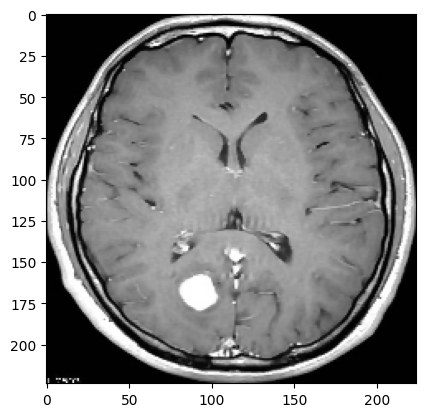

In [14]:
plt.imshow(x_train[0])
print(y_train[0])

## Creating a directory to save the augmented images

In [18]:
directory = 'preview'

# Check if the directory already exists
if os.path.exists(directory):
    print(f"Directory '{directory}' already exists. Deleting it...")
    shutil.rmtree(directory)  # Remove the directory and its contents recursively
    print(f"Directory '{directory}' deleted.")

# Create the directory
print(f"Creating directory '{directory}'...")
os.mkdir(directory)
print(f"Directory '{directory}' created.")

Directory 'preview' already exists. Deleting it...
Directory 'preview' deleted.
Creating directory 'preview'...
Directory 'preview' created.


## Augmentation (transformations etc.)

In [19]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

sample_x = x_train[0]  
sample_x = sample_x.reshape((1,) + sample_x.shape) 

i = 0
for batch in demo_datagen.flow(sample_x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

# Plotting the results of augmentation

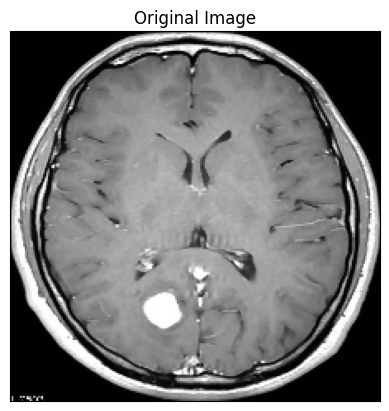

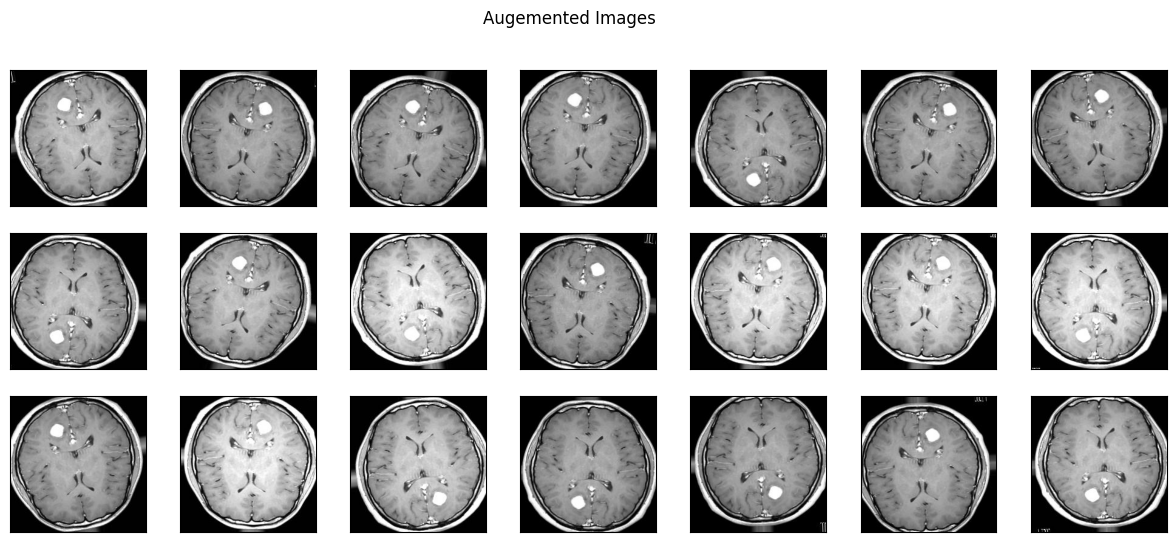

In [20]:
plt.imshow(x_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()